In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from datetime import datetime
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import scipy.stats as stats
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency

In [21]:
plt.rcParams['figure.figsize'] = [6, 4]

In [3]:
Demographic=pd.read_csv("data/Demographic.txt", sep='\t')
Demographic.set_index("Cust_ID", inplace=True)
Demographic

,name,birth_year,education_level,dependents,City
Cust_ID,,,,,
4,Mr Daniel Spencer,2002,Master,1,NaN
5,Miss Abigail Garcia,1994,high school,0,Birmingham
6,Miss Laura Williams,2005,PhD,1,NaN
9,Mr Justin Hamilton,2003,high school,0,NaN
10,Mr Steven Vaughn,2002,less than high school,0,NaN
...,...,...,...,...,...
6489,Miss Jamie Young,1995,Bachelor,0,NaN
6491,Mr Cody Turner,1996,Master,0,NaN
6492,Mr Paul Ingram,2004,high school,0,Birmingham


In [5]:
#check duplicates
len(Demographic[Demographic.duplicated()])

0

In [6]:
Demographic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             4000 non-null   object
 1   birth_year       4000 non-null   int64 
 2   education_level  4000 non-null   object
 3   dependents       4000 non-null   int64 
 4   City             2019 non-null   object
dtypes: int64(2), object(3)
memory usage: 187.5+ KB


Types seem ok.  
Only City has missing values.

In [10]:
#missing values number
print('Missing values in City are: ', Demographic['City'].isna().sum())
print(f'representing {Demographic['City'].isna().sum()/len(Demographic)*100:.1f}% of the dataset')

Missing values in City are:  1981
representing 49.5% of the dataset


That is a lot. But deleting the column may not be the best option as the cities informed may be interesting info.

In [11]:
Demographic.describe()

,birth_year,dependents
count,4000.000000,4000.000000
mean,1989.299000,0.298000
std,16.398836,0.498757
min,1944.000000,0.000000
25%,1980.000000,0.000000
50%,1997.000000,0.000000
75%,2002.000000,1.000000
max,2006.000000,2.000000


Most clients do not have children.  

Average birth year is 1989, median is 1997, indicating a skewness in the data to older clients.

In [15]:
Demographic.describe(include='O')

,name,education_level,City
count,4000,4000,2019
unique,3892,7,3
top,Mr Michael Jackson,high school,Birmingham
freq,4,1280,1284


Many unique names, which will not add relevant info.  

7 different levels of education, high the most common.

Apparently 3 different cities.

### Birth year to age

Age is a more useful info that birht year. Let's change it.

In [49]:
#create age column and delete birth_year
Demographic['age'] = 2024 - Demographic['birth_year']
Demographic = Demographic.drop(['birth_year'], axis=1)
Demographic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   name             4000 non-null   object
 1   education_level  4000 non-null   object
 2   dependents       4000 non-null   int64 
 3   City             4000 non-null   object
 4   sex              4000 non-null   object
 5   age              4000 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 218.8+ KB


In [47]:
#skewness
Demographic['age'].skew()

1.058954622196828

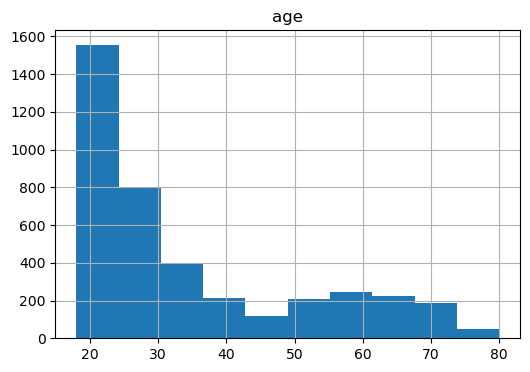

In [48]:
Demographic['age'].hist()
plt.title('age')
plt.show()

Clear right tail.  

No apparent outliers.

### City

In [24]:
Demographic['City'].unique()

array([nan, 'Birmingham', 'Brimingham', 'London'], dtype=object)

In [25]:
Demographic['City']=Demographic['City'].replace('Brimingham', 'Birmingham')
Demographic['City'].value_counts()

City
Birmingham    1319
London         700
Name: count, dtype: int64

Only two cities.   
Let's deal with the missing cities.  

Since we have no information about them, we will create the valu 'other' for the missing values.

In [28]:
#fill NA as 'other'
Demographic['City'] = Demographic['City'].fillna('other')
Demographic['City'].value_counts()

City
other         1981
Birmingham    1319
London         700
Name: count, dtype: int64

In [54]:
#change to snake_case
Demographic = Demographic.rename(columns={'City': 'city'})
Demographic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   education_level  4000 non-null   object
 1   dependents       4000 non-null   int64 
 2   city             4000 non-null   object
 3   sex              4000 non-null   object
 4   age              4000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 187.5+ KB


### Dependents

In [29]:
Demographic['dependents'].value_counts()

dependents
0    2887
1    1034
2      79
Name: count, dtype: int64

There is value 2, although there should be only value 1 and 0.  
We will assume that someone entered the number of children in the system, so we will replace 2 by 1 to indicate True for children.

In [30]:
Demographic.loc[Demographic['dependents'] == 2, 'dependents'] = 1
Demographic['dependents'].value_counts()

dependents
0    2887
1    1113
Name: count, dtype: int64

In [36]:
print(f'{Demographic['dependents'].mean()*100:.1f}% of customers have dependents')

27.8% of customers have dependents


### Gender based on name

In [38]:
# Function to determine gender based on name (Mr and Mrs)
def determinar_sexo(name):
    if name.startswith('Mr'):
        return 'male'
    else:
        return 'female'


In [39]:
#create column sex
Demographic['sex'] = Demographic['name'].apply(determinar_sexo)
Demographic['sex'].value_counts()

sex
female    2368
male      1632
Name: count, dtype: int64

In [40]:
#check total created columns
Demographic['sex'].isna().sum()

0

All customers successfully assigned a gender.

In [50]:
#delete 'name' column
Demographic = Demographic.drop(['name'], axis=1)

### Education

In [41]:
Demographic['education_level'].unique()

array(['Master', 'high school', 'PhD', 'less than high school',
       'Bachelor', 'High School', 'PHD'], dtype=object)

Some mistakes like 'PHD' and 'PhD'

In [42]:
# dictionary to map wrong levels
education_mapping = {
    'PHD': 'PhD',
    'PhD':'PhD',
    'Bachelor':'Bachelor',
    'High School':'High School',
    'high school': 'High School',
    'Master':'Master',
    'less than high school':'less than high school',
    }



In [43]:
# Aplicar o mapeamento na coluna 'education_level'
Demographic['education_level'] = Demographic['education_level'].map(education_mapping)
Demographic['education_level'].value_counts()

education_level
High School              1322
Bachelor                 1023
less than high school     818
Master                    666
PhD                       171
Name: count, dtype: int64

In [44]:
Demographic['education_level'].isna().sum()

0

No empty values.  
All previous values substituted successfully.  
Biggest group is High School education with decreasing number for each education level until PhD.  
Less than High School is the exception to this rule, being the 3rd most frequent.  

May be interesting to group Master and PhD as 'Post Grad' to better characterize the demographics.

In [60]:
### Check df
Demographic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   education_level  4000 non-null   object
 1   dependents       4000 non-null   int64 
 2   city             4000 non-null   object
 3   sex              4000 non-null   object
 4   age              4000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 187.5+ KB


In [62]:
#correct dependents to boolean (just to facilitate in identifying the content of features)
Demographic['dependents'] = Demographic['dependents']>0
Demographic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   education_level  4000 non-null   object
 1   dependents       4000 non-null   bool  
 2   city             4000 non-null   object
 3   sex              4000 non-null   object
 4   age              4000 non-null   int64 
dtypes: bool(1), int64(1), object(3)
memory usage: 160.2+ KB


In short, in Demographic, we corrected:
1) Birmingham mispelled,
2) nr of dependents as 2 (should be binary variable)
3) missing location,
4) lack of 'sex' column - created from names
5) education level mispelled

Changes to dataset:
1) birth_year deleted
    - age created
2) 'name' deleted
    - 'sex' created

# Final Data description

In [69]:
Demographic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 4 to 6496
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   education_level  4000 non-null   object
 1   dependents       4000 non-null   bool  
 2   city             4000 non-null   object
 3   sex              4000 non-null   object
 4   age              4000 non-null   int64 
dtypes: bool(1), int64(1), object(3)
memory usage: 160.2+ KB


In [63]:
Demographic.describe()

,age
count,4000.000000
mean,34.701000
std,16.398836
min,18.000000
25%,22.000000
50%,27.000000
75%,44.000000
max,80.000000


<Axes: xlabel='age', ylabel='Count'>

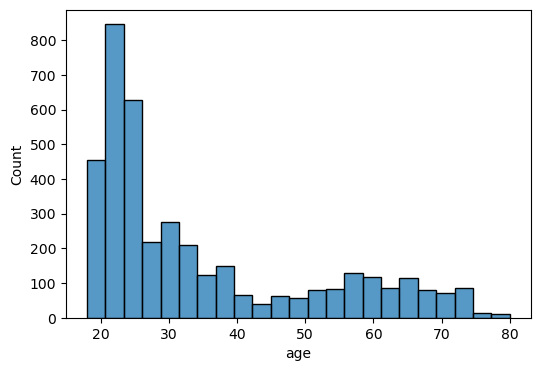

In [66]:
sns.histplot(data=Demographic, x='age')

In [68]:
Demographic.describe(include='O')

,education_level,city,sex
count,4000,4000,4000
unique,5,3,2
top,High School,other,female
freq,1322,1981,2368


## By City

In [76]:
# Average age by city
average_age_by_city = Demographic.groupby('city')['age'].mean()
print("Average age by city:")
print(average_age_by_city)
print()

# Percentage of individuals with dependents by city
percent_dependents_by_city = Demographic.groupby('city')['dependents'].mean() * 100
print("Percentage of individuals with dependents by city:")
print(percent_dependents_by_city)
print()

# Distribution of education levels by city
education_distribution_by_city = Demographic.groupby('city')['education_level'].value_counts(normalize=True) * 100
print("Education level distribution by city:")
print(education_distribution_by_city)


Average age by city:
city
Birmingham    35.475360
London        34.008571
other         34.430086
Name: age, dtype: float64

Percentage of individuals with dependents by city:
city
Birmingham    28.582259
London        27.428571
other         27.460878
Name: dependents, dtype: float64

Education level distribution by city:
city        education_level      
Birmingham  High School              30.629265
            Bachelor                 27.141774
            less than high school    20.166793
            Master                   17.058378
            PhD                       5.003791
London      High School              34.285714
            Bachelor                 24.857143
            less than high school    19.857143
            Master                   17.142857
            PhD                       3.857143
other       High School              34.225139
            Bachelor                 24.785462
            less than high school    20.848057
            Master            

**Very similar patterns accross cities.**

## By sex

In [75]:
# Average age by sex
average_age_by_sex = Demographic.groupby('sex')['age'].mean()
print("Average age by sex:")
print(average_age_by_sex)
print()

# Percentage of individuals with dependents by sex
percent_dependents_by_sex = Demographic.groupby('sex')['dependents'].mean() * 100
print("Percentage of individuals with dependents by sex:")
print(percent_dependents_by_sex)
print()

# Distribution of education levels by sex
education_distribution_by_sex = Demographic.groupby('sex')['education_level'].value_counts(normalize=True) * 100
print("Education level distribution by sex:")
print(education_distribution_by_sex)


Average age by sex:
sex
female    32.160895
male      38.386642
Name: age, dtype: float64

Percentage of individuals with dependents by sex:
sex
female    27.576014
male      28.186275
Name: dependents, dtype: float64

Education level distribution by sex:
sex     education_level      
female  High School              33.192568
        Bachelor                 24.746622
        less than high school    20.777027
        Master                   17.187500
        PhD                       4.096284
male    High School              32.843137
        Bachelor                 26.776961
        less than high school    19.975490
        Master                   15.870098
        PhD                       4.534314
Name: proportion, dtype: float64


**Males are 6 years older then females: 38 vs 32**  

Similar education level and nr of dependents.

## By education level

In [79]:
# Average age by education level
average_age_by_education = Demographic.groupby('education_level')['age'].mean()
print("Average age by education level:")
print(average_age_by_education)
print()

# Percentage of individuals with dependents by education level
percent_dependents_by_education = Demographic.groupby('education_level')['dependents'].mean() * 100
print("Percentage of individuals with dependents by education level:")
print(percent_dependents_by_education)


Average age by education level:
education_level
Bachelor                 35.048876
High School              34.861573
Master                   33.581081
PhD                      35.333333
less than high school    34.786064
Name: age, dtype: float64

Percentage of individuals with dependents by education level:
education_level
Bachelor                 24.437928
High School              28.214826
Master                   21.621622
PhD                      28.070175
less than high school    36.430318
Name: dependents, dtype: float64


**Interestingly, different education levels have the same average age**  

**The lower the education level, the more likely to have dependents.**  
**Exception**: PhD with same proportion of High School  



### Correlation between Age and Having Dependents - no correlation

In [86]:
# Calculate point-biserial correlation
correlation, p_value = stats.pointbiserialr(Demographic['dependents'], Demographic['age'])
print(f"Correlation between age and having dependents: {correlation:.3f}")
print(f"P-value of the correlation: {p_value:.3f}")

Correlation between age and having dependents: 0.004
P-value of the correlation: 0.810


### Age across Education Levels - no difference

In [87]:
groups = Demographic.groupby('education_level')['age'].apply(list)

# Perform ANOVA test
f_stat, p_value = f_oneway(*groups)
print(f"F-statistic: {f_stat:.3f}")
print(f"P-value: {p_value:.3f}")

F-statistic: 0.992
P-value: 0.410


###  Education Level and Dependents - there is a difference

In [89]:
contingency_table = pd.crosstab(Demographic['education_level'], Demographic['dependents'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2:.3f}")
print(f"P-value: {p:.3f}")

Chi-square statistic: 48.873
P-value: 0.000


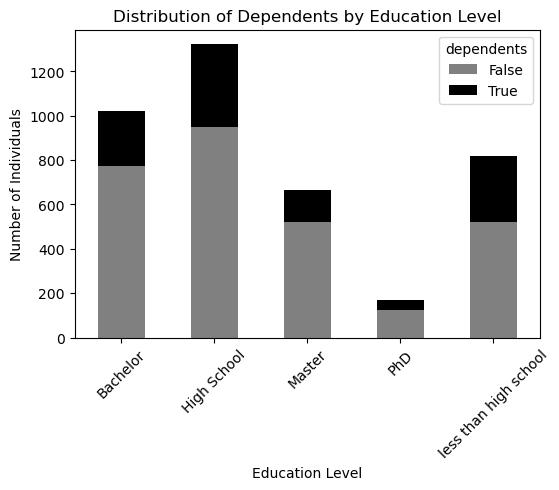

In [92]:
# Plotting a stacked bar graph
contingency_table.plot(kind='bar', stacked=True, color=['gray', 'black'])
plt.title('Distribution of Dependents by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Number of Individuals')
plt.xticks(rotation=45)  # Rotates labels to improve readability
plt.show()

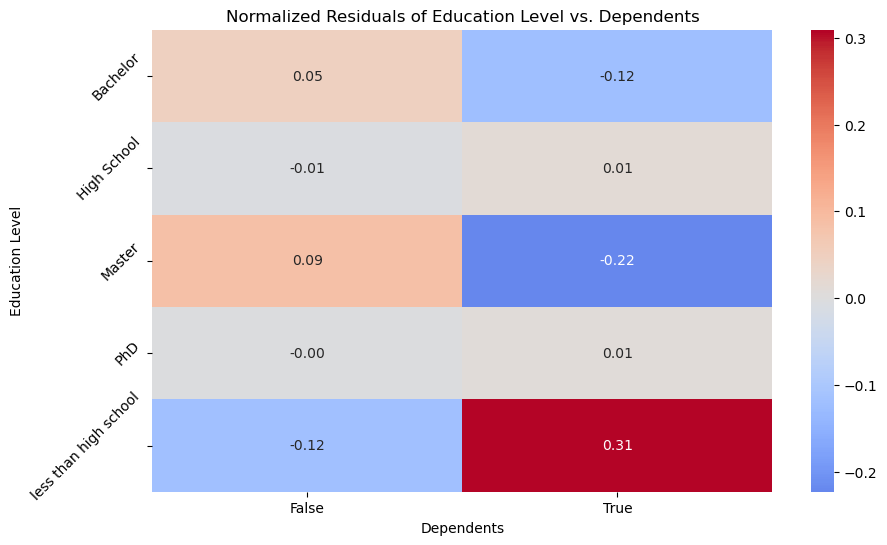

In [97]:
# Calculate the residuals (observed - expected)
residuals = contingency_table - expected

# Normalize residuals by expected
normalized_residuals = residuals / expected

# Plotting a heatmap of the normalized residuals
plt.figure(figsize=(10, 6))
sns.heatmap(normalized_residuals, annot=True, cmap="coolwarm", fmt=".2f", center=0)
plt.title('Normalized Residuals of Education Level vs. Dependents')
plt.xlabel('Dependents')
plt.ylabel('Education Level')
plt.yticks(rotation=45)
plt.show()


**'less than high school'** are **more** likely to have dependents than expected.  

**'Master' and 'Bachelor'** are **less** likely to have children.